In [15]:
import warnings
import random
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline

In [16]:
data = pd.read_csv('/home/dangdbh/Downloads/time-series-prediction-testcases/demo_aws_forecast/input_AWS_predict/request.csv', engine='python', names=['timestamp', 'metric_value'], skiprows=1)
data['timestamp']=pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')
data.set_index(['timestamp'], inplace=True)

In [17]:
data2 = pd.read_csv('/home/dangdbh/Downloads/time-series-prediction-testcases/demo_aws_forecast/input_AWS_predict/data_transfer.csv', engine='python', names=['timestamp', 'metric_value'], skiprows=1)
data2['timestamp']=pd.to_datetime(data2['timestamp'], format='%Y-%m-%d %H:%M:%S')
data2.set_index(['timestamp'], inplace=True)

In [18]:
predict_len =275

In [19]:
data.head()
# data['s3.request'] = data['metric_value']

,metric_value
timestamp,
2019-11-30 17:00:00,6150.0
2019-11-30 18:00:00,3800.0
2019-11-30 19:00:00,2960.0
2019-11-30 20:00:00,2190.0
2019-11-30 21:00:00,1160.0


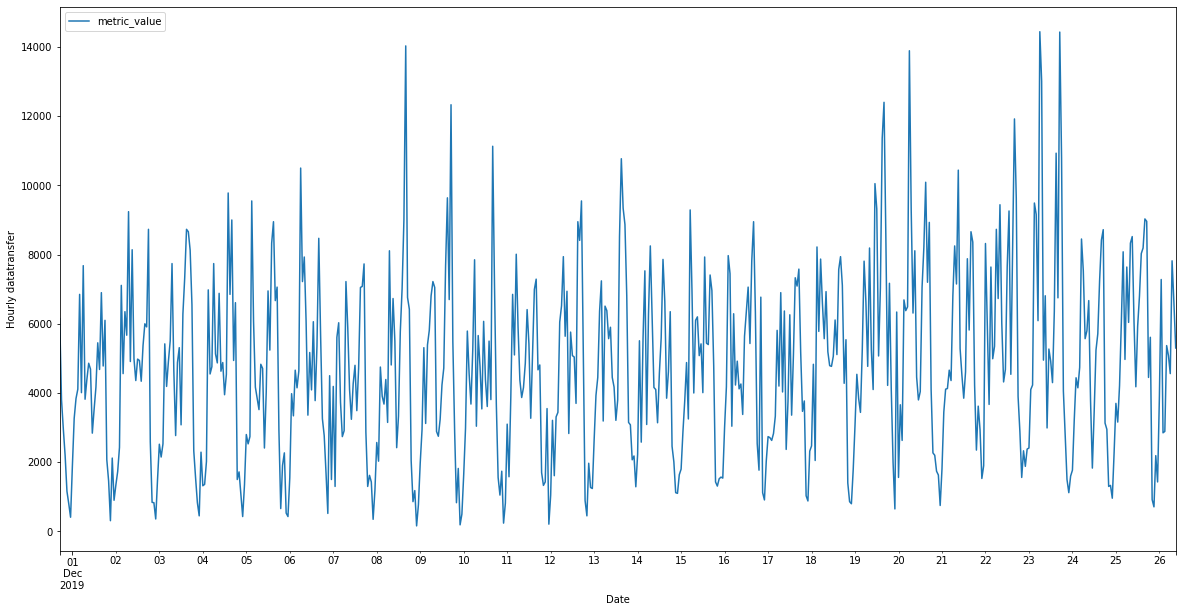

In [20]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
# # plt.rcParams.update({'font.size': 12})
# # plt.style.use('ggplot')
data.plot()
plt.ylabel('Hourly datatransfer')
plt.xlabel('Date')
plt.legend(loc=2)
plt.show()

In [21]:
train_data = data['2019-11-30 17:00:00':'2019-12-19 22:00:00']
test_data = data['2019-12-19 23:00:00':'2019-12-26 09:00:00']
train_len = len(train_data)
test_len = len(test_data)

In [22]:
### ARIMA model

In [23]:
p = q = d = range(0, 3)
pdq = list(itertools.product(p, d, q))

In [30]:
seasonal_pdq = [(x[0], x[1], x[2], 1) for x in list(itertools.product(p, d, q))]

In [31]:
train_data.head()

,metric_value
timestamp,
2019-11-30 17:00:00,6150.0
2019-11-30 18:00:00,3800.0
2019-11-30 19:00:00,2960.0
2019-11-30 20:00:00,2190.0
2019-11-30 21:00:00,1160.0


In [32]:
warnings.filterwarnings("ignore")

In [33]:
AIC = []
ARIMA_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train_data,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            ARIMA_model.append([param, param_seasonal])
        except Exception as e:
            print(e)
            continue

In [34]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), ARIMA_model[AIC.index(min(AIC))][0],ARIMA_model[AIC.index(min(AIC))][1]))

The smallest AIC is 8226.332550947078 for model SARIMAX(2, 0, 2)x(1, 1, 2, 1)


In [35]:
mod = SARIMAX(train_data,
              order=ARIMA_model[AIC.index(min(AIC))][0],
              seasonal_order=ARIMA_model[AIC.index(min(AIC))][1],
              enforce_stationarity=False,
              enforce_invertibility=False)
arima_fit = mod.fit()

In [36]:
# best param

In [52]:
mod = SARIMAX(train_data,
              order=(0,0,0),
              seasonal_order=(2,2,2,24),
              enforce_stationarity=False,
              enforce_invertibility=False)
arima_fit = mod.fit()

In [53]:
pred2 = arima_fit.get_forecast('2019-12-31 09:00:00')
pred2_ci = pred2.conf_int()

In [54]:
pred3 = arima_fit.predict(start='2019-12-19 23:00:00', end='2019-12-31 09:00:00')

In [55]:
pred2.prediction_results

In [56]:
arima_fit.get_forecast()

In [57]:
pred2_ci.head()

,lower metric_value,upper metric_value
2019-12-19 23:00:00,-1641.006076,5472.547284
2019-12-20 00:00:00,-681.243734,6432.309626
2019-12-20 01:00:00,1089.266954,8202.820314
2019-12-20 02:00:00,277.761171,7391.314531
2019-12-20 03:00:00,1661.112510,8774.665870


In [58]:
pred2.predicted_mean['2019-12-26 10:00:00':'2019-12-31 09:00:00']

2019-12-26 10:00:00     4190.731586
2019-12-26 11:00:00     8171.900964
2019-12-26 12:00:00     8343.307592
2019-12-26 13:00:00     6171.938539
2019-12-26 14:00:00     6328.163461
2019-12-26 15:00:00    10446.943251
2019-12-26 16:00:00    10518.821950
2019-12-26 17:00:00     7546.166186
2019-12-26 18:00:00     4271.288666
2019-12-26 19:00:00     6294.385207
2019-12-26 20:00:00     4482.878872
2019-12-26 21:00:00     1737.042806
2019-12-26 22:00:00      965.319341
2019-12-26 23:00:00     2385.189396
2019-12-27 00:00:00     3246.535182
2019-12-27 01:00:00     5705.096113
2019-12-27 02:00:00     4128.327288
2019-12-27 03:00:00     5134.788659
2019-12-27 04:00:00     5244.392558
2019-12-27 05:00:00     9127.981482
2019-12-27 06:00:00     6390.178652
2019-12-27 07:00:00     5411.729058
2019-12-27 08:00:00     7674.640227
2019-12-27 09:00:00     5759.747503
2019-12-27 10:00:00     4210.256185
2019-12-27 11:00:00     8407.682879
2019-12-27 12:00:00     8591.053513
2019-12-27 13:00:00     6246

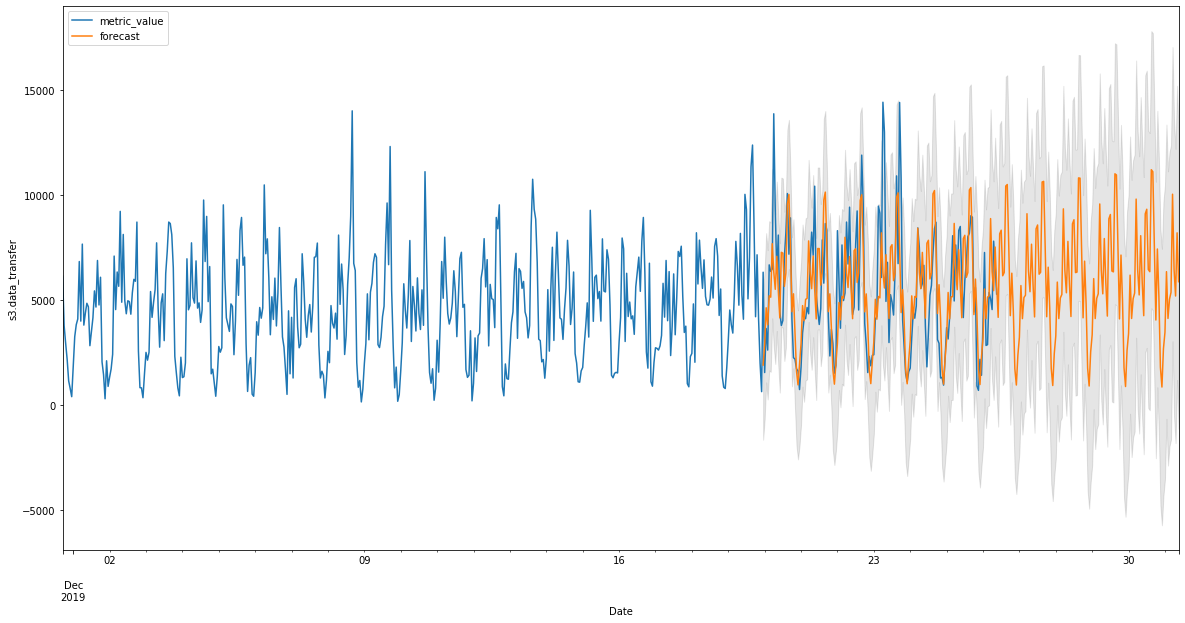

In [59]:
ax = data.plot(figsize=(20, 10))
pred2.predicted_mean.plot(ax=ax, label='forecast')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('s3.data_transfer')
plt.xlabel('Date')
plt.legend(loc=2)
plt.show()


In [60]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data['metric_value'], pred2.predicted_mean['2019-12-19 23:00:00':'2019-12-26 09:00:00']))
rmse = round(rmse, 3)
rmse

2370.96

In [61]:
# Mean Absolute Percentage Error
abs_error = np.abs(test_data['metric_value']-pred2.predicted_mean['2019-12-19 23:00:00':'2019-12-26 09:00:00'])
actual = test_data['metric_value']
mape = np.round(np.mean(np.abs(abs_error/actual)),3)
mape

0.402

In [62]:
# Exponetial smoothing

In [63]:
pred = test_data.copy()

In [64]:
ets_fit = ExponentialSmoothing(train_data['metric_value'],seasonal_periods=24 ,trend='add', seasonal='add', freq='H', damped=True).fit(damping_slope=0.2)
ets_fit.params

{'damping_slope': 0.2,
 'initial_level': 7042.500000000113,
 'initial_seasons': array([ -892.5, -3242.5, -4082.5, -4852.5, -5882.5, -6242.5, -6632.5,
        -5152.5, -3772.5, -3202.5, -2932.5,  -192.5, -3032.5,   637.5,
        -3222.5, -2652.5, -2182.5, -2352.5, -4202.5, -3512.5, -2872.5,
        -1592.5, -2362.5,  -142.5]),
 'initial_slope': 16.92708333336486,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.052631578947366676,
 'smoothing_seasonal': 0.1578947368421331,
 'smoothing_slope': 0.05263157894736842,
 'use_boxcox': False}

In [65]:
Forecasting = ets_fit.forecast(predict_len)

In [66]:
idx = pd.date_range(start='2019-12-19 23:00:00', periods=predict_len, freq='H')
Forecasting = pd.Series(Forecasting,index=idx)

In [67]:
Forecasting

2019-12-19 23:00:00    2615.657128
2019-12-20 00:00:00    3595.341742
2019-12-20 01:00:00    4759.958495
2019-12-20 02:00:00    4875.003290
2019-12-20 03:00:00    6362.376563
2019-12-20 04:00:00    5942.701223
2019-12-20 05:00:00    7364.961518
2019-12-20 06:00:00    7125.237484
2019-12-20 07:00:00    6825.213493
2019-12-20 08:00:00    6977.821794
2019-12-20 09:00:00    6382.987385
2019-12-20 10:00:00    5069.463000
2019-12-20 11:00:00    6556.333138
2019-12-20 12:00:00    6662.307115
2019-12-20 13:00:00    6247.369028
2019-12-20 14:00:00    7027.284177
2019-12-20 15:00:00    8971.609967
2019-12-20 16:00:00    9537.273046
2019-12-20 17:00:00    8270.411046
2019-12-20 18:00:00    5644.351401
2019-12-20 19:00:00    4432.129510
2019-12-20 20:00:00    3622.341850
2019-12-20 21:00:00    2310.070342
2019-12-20 22:00:00    2285.159429
2019-12-20 23:00:00    2615.409322
2019-12-21 00:00:00    3595.292180
2019-12-21 01:00:00    4759.948582
2019-12-21 02:00:00    4875.001308
2019-12-21 03:00:00 

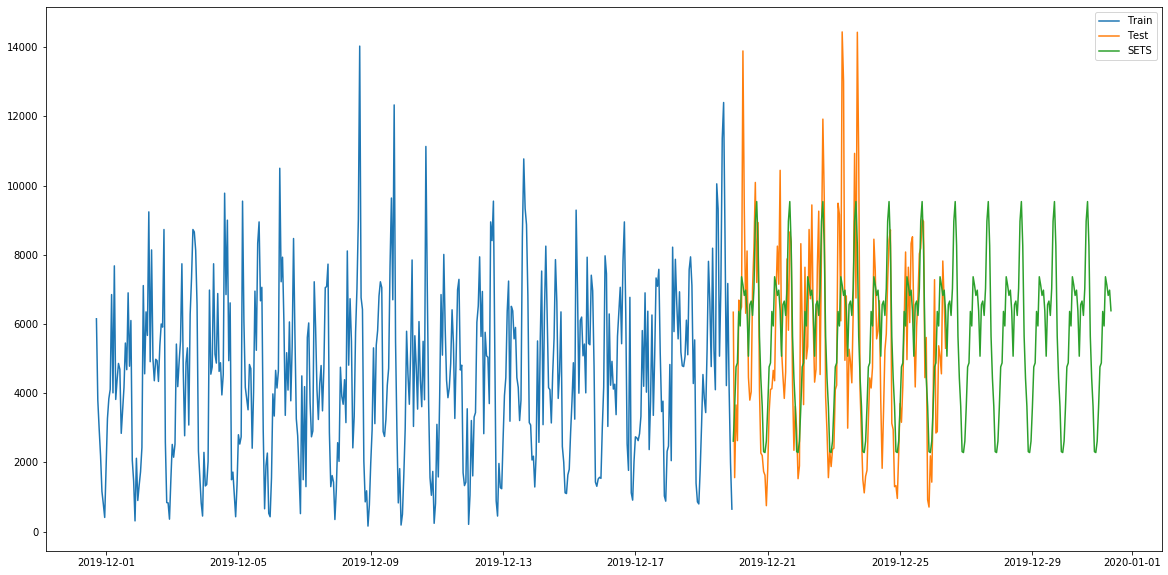

In [68]:
plt.figure(figsize=(20,10))
plt.plot(train_data['metric_value'], label='Train')
plt.plot(test_data['metric_value'], label='Test')
plt.plot(Forecasting, label='SETS')
plt.legend(loc='best')
plt.show()

In [69]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data.metric_value, Forecasting['2019-12-19 23:00:00':'2019-12-26 09:00:00']))
rmse = round(rmse, 3)
rmse

2032.634

In [70]:
# Mean Absolute Percentage Error
abs_error = np.abs(test_data['metric_value']-Forecasting['2019-12-19 23:00:00':'2019-12-26 09:00:00'])
actual = test_data['metric_value']
mape = np.round(np.mean(abs_error/actual),4)
mape

0.4074

In [71]:
# Multiplicative

In [72]:
y_hat_avg = test_data.copy()

In [73]:
mod = ExponentialSmoothing(train_data['metric_value'] ,seasonal_periods=24 ,trend='add', seasonal='mul', freq='H', damped=True)
fit1 = mod.fit(damping_slope=0.3)
fit1.params

{'damping_slope': 0.3,
 'initial_level': 7042.5,
 'initial_seasons': array([0.87326944, 0.53958111, 0.42030529, 0.31096912, 0.16471424,
        0.11359602, 0.05821796, 0.26837061, 0.46432375, 0.54526092,
        0.58359957, 0.97266596, 0.56940007, 1.09052183, 0.54242102,
        0.62335818, 0.69009585, 0.66595669, 0.40326589, 0.50124246,
        0.59211928, 0.77387291, 0.66453674, 0.97976571]),
 'initial_slope': 16.927083333333332,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.05263157894736842,
 'smoothing_seasonal': 0.15789473684210525,
 'smoothing_slope': 0.05263157894736842,
 'use_boxcox': False}

In [74]:
Forecasting

2019-12-19 23:00:00    2615.657128
2019-12-20 00:00:00    3595.341742
2019-12-20 01:00:00    4759.958495
2019-12-20 02:00:00    4875.003290
2019-12-20 03:00:00    6362.376563
2019-12-20 04:00:00    5942.701223
2019-12-20 05:00:00    7364.961518
2019-12-20 06:00:00    7125.237484
2019-12-20 07:00:00    6825.213493
2019-12-20 08:00:00    6977.821794
2019-12-20 09:00:00    6382.987385
2019-12-20 10:00:00    5069.463000
2019-12-20 11:00:00    6556.333138
2019-12-20 12:00:00    6662.307115
2019-12-20 13:00:00    6247.369028
2019-12-20 14:00:00    7027.284177
2019-12-20 15:00:00    8971.609967
2019-12-20 16:00:00    9537.273046
2019-12-20 17:00:00    8270.411046
2019-12-20 18:00:00    5644.351401
2019-12-20 19:00:00    4432.129510
2019-12-20 20:00:00    3622.341850
2019-12-20 21:00:00    2310.070342
2019-12-20 22:00:00    2285.159429
2019-12-20 23:00:00    2615.409322
2019-12-21 00:00:00    3595.292180
2019-12-21 01:00:00    4759.948582
2019-12-21 02:00:00    4875.001308
2019-12-21 03:00:00 

In [75]:
Forecasting = fit1.forecast(predict_len)
idx = pd.date_range(start='2019-12-19 23:00:00', periods=predict_len, freq='H')
Forecasting = pd.Series(Forecasting,index=idx)

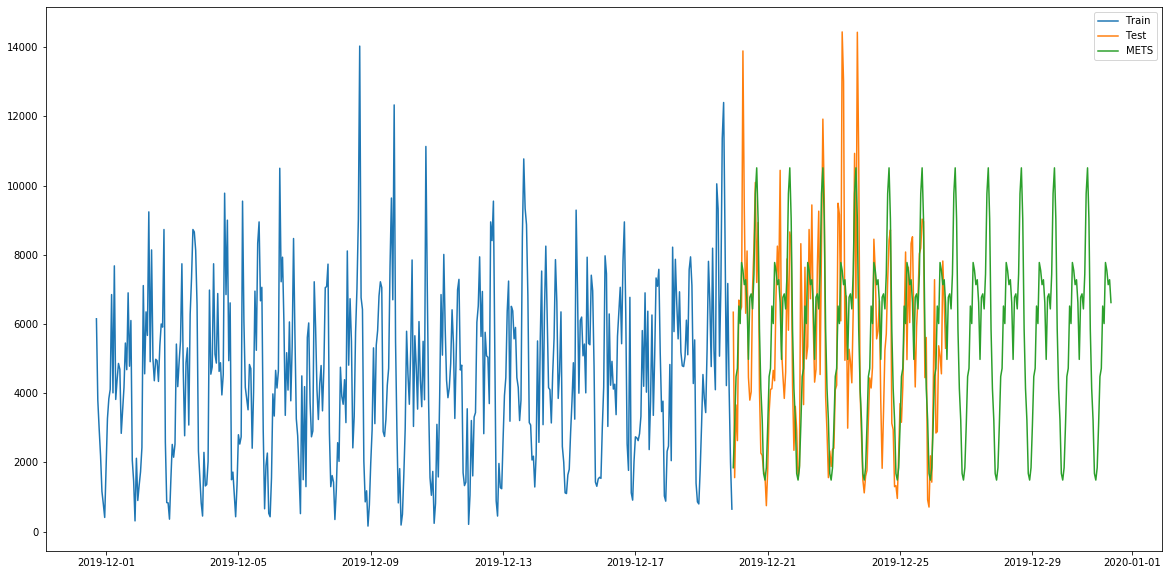

In [76]:
plt.figure(figsize=(20,10))
plt.plot(train_data['metric_value'], label='Train')
plt.plot(test_data['metric_value'], label='Test')
plt.plot(Forecasting, label='METS')
plt.legend(loc='best')
plt.show()

In [77]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data.metric_value, Forecasting['2019-12-19 23:00:00':'2019-12-26 09:00:00']))
rmse = round(rmse, 3)
rmse

2042.375

In [78]:
# Mean Absolute Percentage Error
abs_error = np.abs(test_data['metric_value']-Forecasting['2019-12-19 23:00:00':'2019-12-26 09:00:00'])
actual = test_data['metric_value']
mape = np.round(np.mean(abs_error/actual),4)
mape

0.3634

In [79]:
# NPTS

In [80]:
from gluonts.model.npts import NPTSEstimator, NPTSPredictor
from gluonts.trainer import Trainer

In [81]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [{"start": data.index[0], "target": data.metric_value[:"2019-12-19 22:00:00"]}],
    freq = "H"
)

In [83]:
estimator = NPTSEstimator(freq="H", prediction_length=predict_len)
# predictor = estimator.train(training_data=training_data)
predictor = NPTSPredictor(context_length=train_len, freq="H", prediction_length=predict_len)

In [84]:
idx = pd.date_range(start='2019-12-19 23:00:00', periods=predict_len, freq='H')
Forecasting = pd.Series(Forecasting,index=idx)

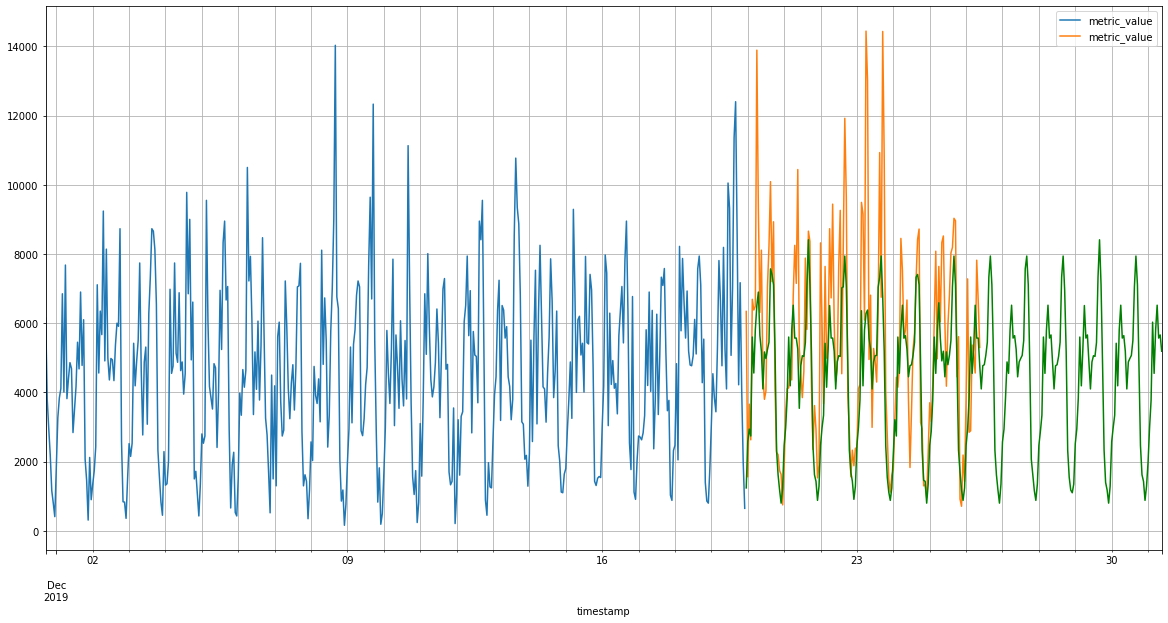

In [85]:


from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(training_data, predictor.predict(training_data)):
#     to_pandas(test_entry)[:].plot(linewidth=2)
#     idx = pd.date_range(start='2019-12-19 23:00:00', periods=predict_len, freq='H')
#     Forecasting = pd.Series(forecast.median,index=idx)
    ax = train_data.plot()
    test_data.plot(ax=ax)
    forecast.plot(color='g', prediction_intervals=[0.0])
    NPTS_forecast = forecast
#     Forecasting.plot(color='r', ls='--')
plt.grid(which='both')

In [87]:
NPTS_forecast.median

array([1240., 2570., 2940., 2740., 5600., 4560., 5810., 6510., 6900.,
       5640., 5190., 4100., 5170., 4980., 5240., 5450., 7570., 7410.,
       7110., 5180., 2330., 1620., 1180.,  800., 1240., 2470., 2980.,
       3840., 5600., 4190., 5810., 6520., 5570., 5570., 5250., 3540.,
       4770., 5060., 5040., 5440., 7050., 8410., 7110., 5180., 2460.,
       1620., 1430.,  880., 1290., 2470., 2980., 3340., 5420., 4150.,
       5250., 6510., 5570., 5570., 5190., 4100., 4880., 5060., 5040.,
       7020., 7050., 7940., 7060., 4810., 2330., 1690., 1430.,  910.,
       1290., 2470., 2980., 3770., 6360., 4190., 5810., 6280., 6380.,
       5570., 5250., 4100., 4880., 5060., 5070., 7040., 7330., 7940.,
       6760., 5180., 2460., 1550., 1120.,  880., 1240., 2230., 3210.,
       2740., 5600., 4550., 5810., 6520., 5570., 5640., 5250., 4450.,
       4770., 4800., 5070., 5450., 7330., 7410., 7110., 4810., 2330.,
       1460., 1430.,  800., 1350., 2470., 2870., 3770., 5600., 4550.,
       5810., 6590.,

In [88]:
NPTS_forecast.quantile(0.1)

array([ 410., 1340., 1360., 1610., 3310., 3330., 3190., 3850., 4370.,
       4120., 4100., 2410., 3760., 3210., 3490., 4340., 5350., 6000.,
       4670., 2870.,  890.,  840.,  520.,  190.,  430., 1320., 1580.,
       2020., 3310., 3250., 3190., 3850., 3820., 4030., 2890., 2410.,
       3140., 3330., 3490., 4340., 5350., 6700., 4670., 2930., 1300.,
        840.,  830.,  240.,  430., 1320., 1580., 2020., 3120., 3250.,
       3190., 3850., 3820., 4030., 2890., 2410., 3140., 3530., 3360.,
       5100., 5350., 6670., 4670., 2870., 1300.,  830.,  860.,  190.,
        430., 1050., 1360., 2020., 3310., 3250., 3190., 3150., 4000.,
       4120., 4100., 2410., 3140., 3210., 3490., 4720., 5370., 6670.,
       4670., 2930.,  890.,  840.,  830.,  190.,  430., 1320., 1730.,
       2050., 3310., 3250., 3190., 3850., 3820., 4030., 4100., 2750.,
       2840., 3330., 3360., 4720., 4680., 6000., 4940., 2870., 1300.,
        840.,  860.,  190.,  430., 1320., 1360., 2050., 3120., 3250.,
       3190., 3850.,

In [90]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data.metric_value, NPTS_forecast.median[:test_len]))
rmse = round(rmse, 3)
rmse

2169.543

In [91]:
# Mean Absolute Percentage Error
abs_error = np.abs(test_data['metric_value'] - NPTS_forecast.median[:test_len])
actual = test_data['metric_value']
mape = np.round(np.mean(abs_error/actual),4)
mape

0.2759

In [93]:
#Prophet

In [95]:
from fbprophet import Prophet

In [96]:
data = pd.read_csv('/home/dangdbh/Downloads/time-series-prediction-testcases/demo_aws_forecast/input_AWS_predict/request.csv', engine='python', names=['metric_name','timestamp', 'metric_value'], skiprows=1)

In [97]:
df = data[:train_len]
# df = data

In [98]:
df['ds'] = df['timestamp']
df['y'] = df['metric_value']

In [99]:
df = df.drop(labels=['metric_name','timestamp', 'metric_value'], axis=1)

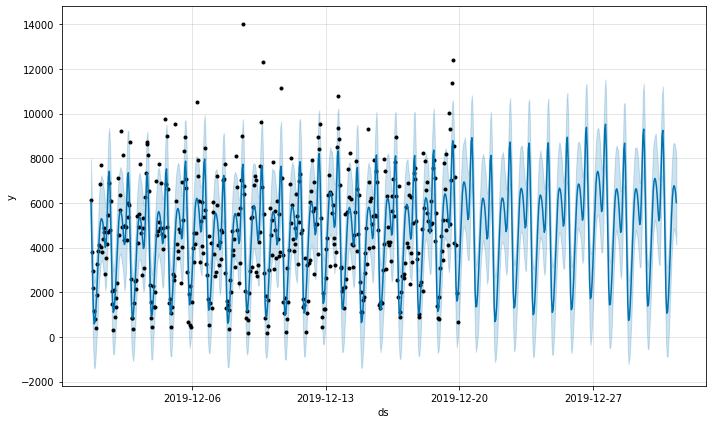

In [103]:
m = Prophet(seasonality_mode=random.choice(['additive','multiplicative']),yearly_seasonality=False)
# m = Prophet()
# m.add_country_holidays(country_name='VN')
m.fit(df)
future = m.make_future_dataframe(predict_len, freq='H')
forecast = m.predict(future)
fig = m.plot(forecast)

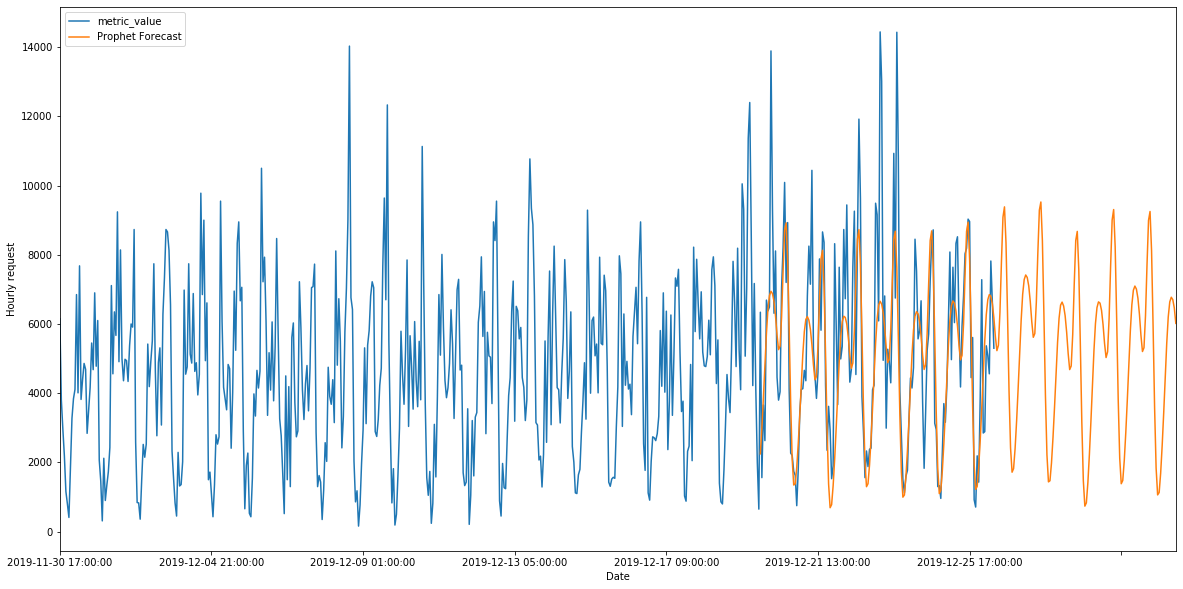

In [104]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
# # plt.rcParams.update({'font.size': 12})
# # plt.style.use('ggplot')
# data['timestamp']=pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')
data.set_index(['timestamp'], inplace=True)
ax = data.metric_value.plot()
forecast[-predict_len:].yhat.plot(ax=ax, label='Prophet Forecast')
plt.ylabel('Hourly request')
plt.xlabel('Date')
plt.legend(loc=2)
plt.show()

In [105]:
forecast

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yhat
0,2019-11-30 17:00:00,4268.626218,4268.626218,4268.626218,4155.327851,7952.874430,0.0,0.0,0.0,0.517143,0.517143,0.517143,0.418693,0.418693,0.418693,-0.098450,-0.098450,-0.098450,6055.868726
1,2019-11-30 18:00:00,4269.715833,4269.715833,4269.715833,2449.465658,6357.163898,0.0,0.0,0.0,0.121808,0.121808,0.121808,0.022869,0.022869,0.022869,-0.098939,-0.098939,-0.098939,4367.359637
2,2019-11-30 19:00:00,4270.805448,4270.805448,4270.805448,610.694719,4579.333132,0.0,0.0,0.0,-0.309245,-0.309245,-0.309245,-0.407903,-0.407903,-0.407903,-0.098658,-0.098658,-0.098658,2528.731542
3,2019-11-30 20:00:00,4271.895062,4271.895062,4271.895062,-721.735828,3039.793476,0.0,0.0,0.0,-0.627271,-0.627271,-0.627271,-0.724894,-0.724894,-0.724894,-0.097624,-0.097624,-0.097624,1175.223459
4,2019-11-30 21:00:00,4272.984677,4272.984677,4272.984677,-1415.780139,2445.168324,0.0,0.0,0.0,-0.766411,-0.766411,-0.766411,-0.862272,-0.862272,-0.862272,-0.095861,-0.095861,-0.095861,588.510434
5,2019-11-30 22:00:00,4274.074292,4274.074292,4274.074292,-1310.127881,2555.391063,0.0,0.0,0.0,-0.751106,-0.751106,-0.751106,-0.844509,-0.844509,-0.844509,-0.093403,-0.093403,-0.093403,664.579033
6,2019-11-30 23:00:00,4275.163907,4275.163907,4275.163907,-789.194931,3030.647261,0.0,0.0,0.0,-0.645187,-0.645187,-0.645187,-0.735475,-0.735475,-0.735475,-0.090288,-0.090288,-0.090288,1130.889657
7,2019-12-01 00:00:00,4276.253522,4276.253522,4276.253522,-85.736342,3796.223177,0.0,0.0,0.0,-0.496854,-0.496854,-0.496854,-0.583415,-0.583415,-0.583415,-0.086560,-0.086560,-0.086560,1781.423842
8,2019-12-01 01:00:00,4277.343137,4277.343137,4277.343137,495.549702,4541.379887,0.0,0.0,0.0,-0.323566,-0.323566,-0.323566,-0.405837,-0.405837,-0.405837,-0.082272,-0.082272,-0.082272,2541.437887
9,2019-12-01 02:00:00,4278.432752,4278.432752,4278.432752,1486.781202,5173.838769,0.0,0.0,0.0,-0.134333,-0.134333,-0.134333,-0.211810,-0.211810,-0.211810,-0.077477,-0.077477,-0.077477,3372.218033


In [106]:
forecast.quantile()

trend                         4734.523119
trend_lower                   4734.523119
trend_upper                   4734.523119
yhat_lower                    3219.248475
yhat_upper                    7017.934145
additive_terms                   0.000000
additive_terms_lower             0.000000
additive_terms_upper             0.000000
daily                            0.047312
daily_lower                      0.047312
daily_upper                      0.047312
multiplicative_terms             0.082129
multiplicative_terms_lower       0.082129
multiplicative_terms_upper       0.082129
weekly                          -0.002018
weekly_lower                    -0.002018
weekly_upper                    -0.002018
yhat                          5122.508103
Name: 0.5, dtype: float64

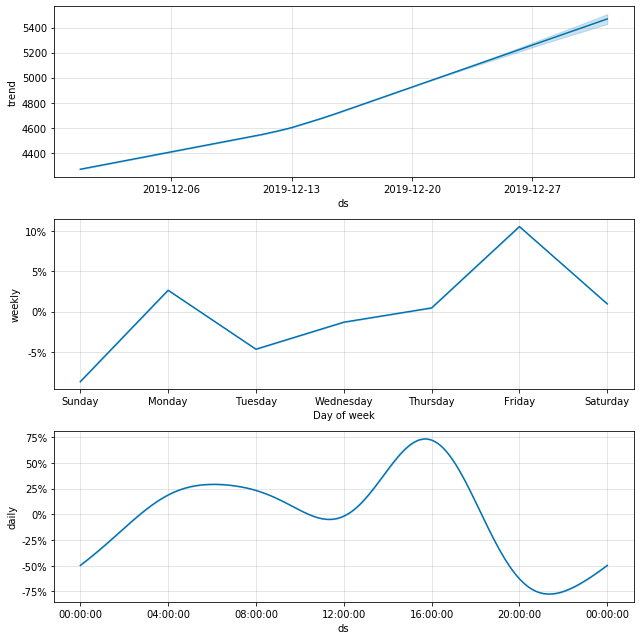

In [107]:
fig = m.plot_components(forecast)

In [108]:
#prophet AWS

In [109]:
from gluonts.model.prophet import ProphetPredictor
from fbprophet import Prophet

In [110]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [{"start": data.index[0], "target": data.metric_value[:"2019-12-19 22:00:00"]}],
    freq = "H"
)

In [111]:
# estimator = NPTSEstimator(freq="H", prediction_length=predict_len)
# predictor = estimator.train(training_data=training_data)
m = Prophet(seasonality_mode=random.choice(['additive','multiplicative']),yearly_seasonality=False)
prophet_params = {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False}
predictor = ProphetPredictor(prophet_params=prophet_params, freq="H", prediction_length=predict_len)

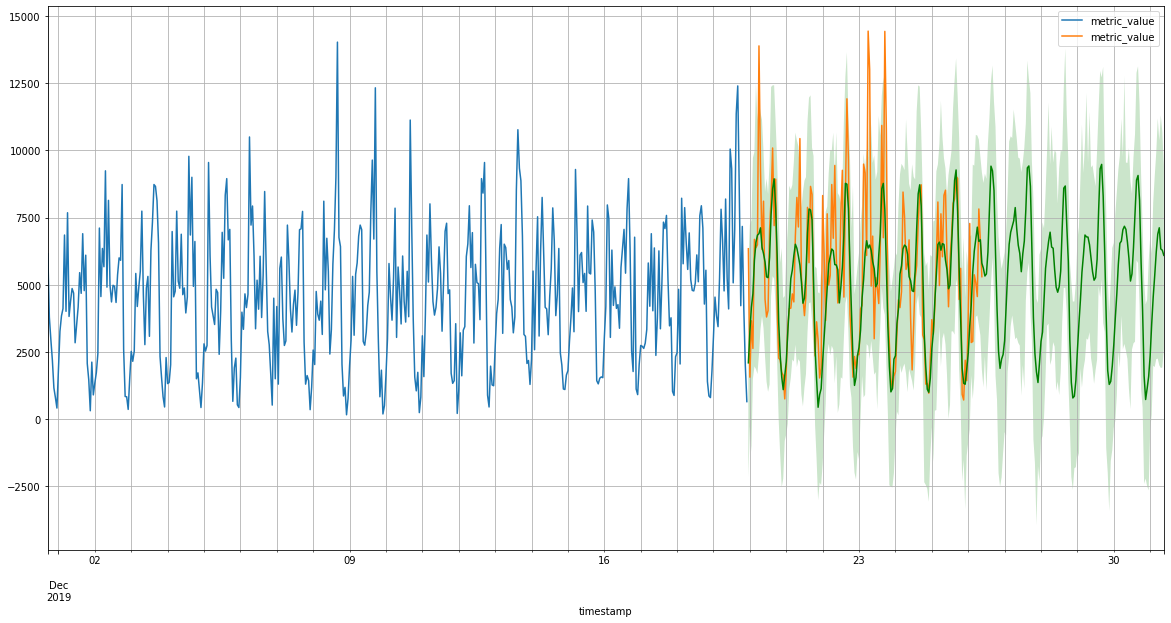

In [112]:
from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(training_data, predictor.predict(training_data)):
#     to_pandas(test_entry)[:].plot(linewidth=2)
#     idx = pd.date_range(start='2019-12-19 23:00:00', periods=predict_len, freq='H')
#     Forecasting = pd.Series(forecast.median,index=idx)
    ax = train_data.plot()
    test_data.plot(ax=ax)
    forecast.plot(color='g', prediction_intervals=[0.0, 99])
    Prophet_forecast = forecast
#     Forecasting.plot(color='r', ls='--')
plt.grid(which='both')

In [129]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data.metric_value, Prophet_forecast.median[:test_len]))
rmse = round(rmse, 3)
rmse

1986.513

In [130]:
# Mean Absolute Percentage Error
abs_error = np.abs(test_data['metric_value'] - Prophet_forecast.median[:test_len])
actual = test_data['metric_value']
mape = np.round(np.mean(abs_error/actual),4)
mape

0.2815

In [113]:
from gluonts.model.forecast import Quantile

In [114]:
num_samples = 100

In [115]:
samples = Prophet_forecast.samples

In [116]:
test = np.sort(samples, axis=0)

In [117]:
Prophet_forecast.quantile(0.5)

array([2093.4166715 , 3248.23415876, 4160.81772287, 4667.68862985,
       5905.746042  , 6573.66954903, 6846.28558349, 6900.90814046,
       7117.85716316, 6397.01730902, 6159.24922072, 5850.66033386,
       5291.15885179, 5263.51401722, 6016.69905497, 7616.56854709,
       8568.8142921 , 8943.15908082, 7866.9154366 , 6103.32368799,
       3600.32365511, 2370.83655552, 1569.1795224 , 1095.79685378,
       1608.8664824 , 2130.82615728, 3229.537644  , 4221.49304713,
       5229.73805998, 5547.71009285, 6085.99385889, 6507.51821523,
       6358.14949597, 6065.53356335, 5729.9792023 , 5095.83028028,
       4311.90195301, 4500.45066659, 5377.12089154, 6928.41869485,
       7819.77571614, 7783.43992257, 7413.69652802, 5162.98770268,
       2634.71741392, 1471.61116663,  439.45477366,  907.02324488,
       1129.25255767, 2151.079823  , 3079.93966158, 4027.38030796,
       4879.78684136, 5777.95021047, 6056.31920184, 6328.94475311,
       6267.79192482, 5750.87998531, 5735.48418157, 5555.28302

In [120]:
q = Quantile.parse(0.9).value
q

0.9

In [121]:
sample_idx = int(np.round((100 - 1) * q))
sample_idx

89

In [122]:
q90 = test[sample_idx, :]

In [123]:
test

array([[-2165.68493036,  -273.3754488 , -1221.92675433, ...,
         1902.00553879,  1916.81176198,  2604.77228836],
       [-1829.93986334,   400.76143507,   666.34771936, ...,
         2757.42056476,  3145.21934416,  3572.46585347],
       [ -984.90136168,   458.91267479,  1290.43018883, ...,
         2827.0247626 ,  3579.95286174,  3655.78791083],
       ...,
       [ 4873.12253186,  5984.18524734,  7101.24802973, ...,
        10039.72259766,  9396.88633162,  9199.59054093],
       [ 5465.86505564,  6136.93647621,  7132.82547947, ...,
        11141.15609034, 10311.16645233,  9220.02341076],
       [ 5786.63820942,  7236.97428182,  7383.77653754, ...,
        11306.36241452, 10693.21982856,  9421.49767113]])

In [124]:
Prophet_forecast.samples

array([[-208.11172225, 2843.76683901, 4684.69128251, ..., 6805.24074413,
        6451.851365  , 4411.16256334],
       [  44.08444151, 4109.50531613, 4143.04500896, ..., 4495.57519473,
        6444.38326868, 5525.75518347],
       [2618.97376179, 2833.31544087, 4039.77488871, ..., 5080.40256587,
        4357.28283186, 6833.12904452],
       ...,
       [1411.46987554, 4840.33917485, 5072.69555185, ..., 5794.6595765 ,
        6122.03705392, 5219.37020426],
       [ 858.45553286, 1805.32028101, 1806.12174502, ..., 9739.11165496,
        3579.95286174, 8306.33192189],
       [4873.12253186, 6136.93647621, 6118.85318817, ..., 5309.43427208,
        5516.52565476, 7668.20119673]])

1986.513

0.2815

In [ ]:
# DeepAR+

In [131]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [{"start": data.index[0], "target": data.metric_value[:"2019-12-19 22:00:00"]}],
    freq = "H"
)

In [133]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

estimator = DeepAREstimator(freq="H", prediction_length=predict_len, trainer=Trainer(epochs=50))
predictor = estimator.train(training_data=training_data)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:48<00:00,  1.03it/s, avg_epoch_loss=9.17]
INFO:root:Epoch[0] Elapsed time 48.673 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=9.166629
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:14<00:00,  3.50it/s, avg_epoch_loss=8.76]
INFO:root:Epoch[1] Elapsed time 14.293 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.758057
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:14<00:00,  3.48it/s, avg_epoch_loss=8.62]
INFO:root:Epoch[2] Elapsed time 14.367 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.624709
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.59it/s, avg_epoch_loss=8.52]
INFO:root:Epoch[3] Elapsed time 13.924 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.523887
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.934851
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.70it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[37] Elapsed time 13.511 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.928934
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.72it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[38] Elapsed time 13.425 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.913541
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.72it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[39] Elapsed time 13.424 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.891137
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.73it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[40] Elapsed time 13.407 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.876320
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 

In [173]:
estimator.dropout_rate

0.1

In [159]:
train_len

462

In [ ]:
from pathlib import Path
predictor.serialize(Path("/tmp/"))

In [138]:
from gluonts.model.predictor import Predictor
from pathlib import Path
predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

INFO:root:Using CPU


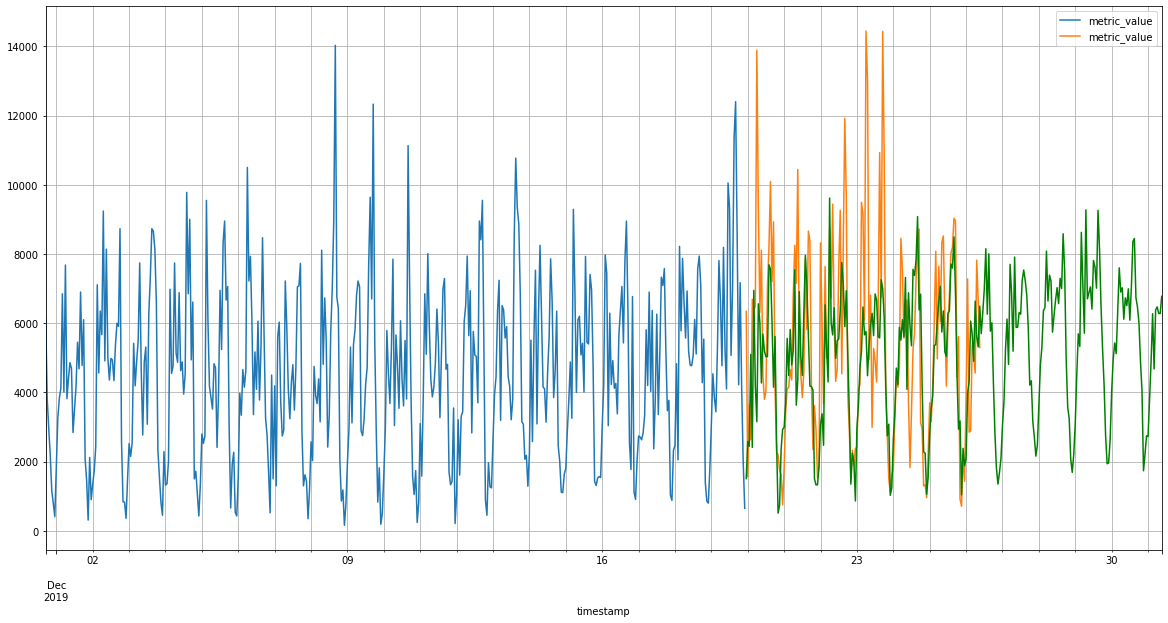

In [146]:
from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(training_data, predictor_deserialized.predict(training_data)):
#     to_pandas(test_entry)[:].plot(linewidth=2)
#     idx = pd.date_range(start='2019-12-19 23:00:00', periods=predict_len, freq='H')
#     Forecasting = pd.Series(forecast.median,index=idx)
    ax = train_data.plot()
    test_data.plot(ax=ax)
    forecast.plot(color='g', prediction_intervals=[0.0])
    DeepAR_forecast = forecast
#     Forecasting.plot(color='r', ls='--')
plt.grid(which='both')

In [147]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data.metric_value, DeepAR_forecast.median[:test_len]))
rmse = round(rmse, 3)
rmse

2468.229

In [148]:
# Mean Absolute Percentage Error
abs_error = np.abs(test_data['metric_value'] - DeepAR_forecast.median[:test_len])
actual = test_data['metric_value']
mape = np.round(np.mean(abs_error/actual),4)
mape

0.3533

In [ ]:
# test with data_transfer

In [149]:
from gluonts.dataset.common import ListDataset
training_data2 = ListDataset(
    [{"start": data2.index[0], "target": data2.metric_value[:"2019-12-19 22:00:00"]}],
    freq = "H"
)

In [150]:
train_data2 = data2['2019-11-30 17:00:00':'2019-12-19 22:00:00']
test_data2 = data2['2019-12-19 23:00:00':'2019-12-26 09:00:00']
train_len = len(train_data2)
test_len = len(test_data2)

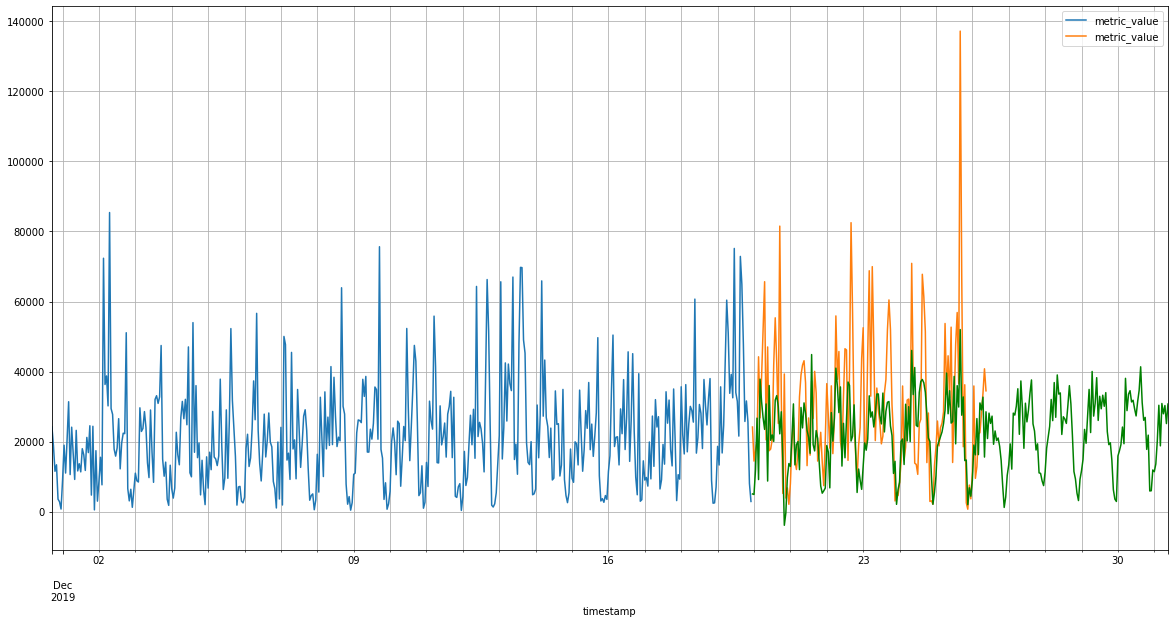

In [154]:
from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(training_data2, predictor_deserialized.predict(training_data2)):
#     to_pandas(test_entry)[:].plot(linewidth=2)
#     idx = pd.date_range(start='2019-12-19 23:00:00', periods=predict_len, freq='H')
#     Forecasting = pd.Series(forecast.median,index=idx)
    ax = train_data2.plot()
    test_data2.plot(ax=ax)
    forecast.plot(color='g', prediction_intervals=[0.0])
    DeepAR_forecast2 = forecast
#     Forecasting.plot(color='r', ls='--')
plt.grid(which='both')

In [155]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data.metric_value, DeepAR_forecast2.median[:test_len]))
rmse = round(rmse, 3)
rmse

19256.807

In [156]:
# Mean Absolute Percentage Error
abs_error = np.abs(test_data['metric_value'] - DeepAR_forecast2.median[:test_len])
actual = test_data['metric_value']
mape = np.round(np.mean(abs_error/actual),4)
mape

3.7517